# Предсказание удержания клиентов интернет-магазина

Необходимо выбрать наилучшую модель для предсказания вероятности снижения покупательсткой активности.

## Цель
С помощью модели необходимо повысить покупательсткую активность различных категорий клиентов
 - выбрать и обучить модель, наилучшим образом предсказывающую покеупательскую способность пользоываелей;
 - выделить сегменты клиентов с учётом выручки бизнеса, покупательской способности и других характеристик пользователей;
 - разработать для каждого выделенного сегмента клиентов стратегии, повышаюшие удержание

## Описание данных:
### Поведение покупателя
- `id` — уникальный идентификатор покупателя в корпоративной базе данных.
- `Покупательская активность` — целевой признак, показывающий класс покупательской активности: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса («премиум» или «стандарт»), зависящий от наличия подписки.
- `Разрешить сообщать` — бинарный признак (да, нет), указывающий, можно ли присылать клиенту дополнительные предложения.
- `Маркет_актив_6_мес` — среднемесячное количество маркетинговых коммуникаций за последние 6 месяцев (рассылки, звонки, реклама).
- `Маркет_актив_тек_мес` — число маркетинговых коммуникаций в текущем месяце.
- `Длительность` — количество дней с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от всех покупок за последние 6 месяцев.
- `Популярная_категория` — наиболее часто покупаемая категория товаров за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — среднее число категорий, просмотренных за один визит за последний месяц.
- `Неоплаченные_продукты_штук_квартал` — количество неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев сервиса, затронувших клиента за последние 3 месяца.
- `Страниц_за_визит` — среднее количество страниц, просмотренных клиентом за визит за последние 3 месяца.
### Выручка от покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период в условных единицах.
### Время, проведённое покупателем на сайте
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.
### Прибыль от покупателя
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли в условных единицах.

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Корреляционный анализ
5) Построение пайплайнов для выбора лучшей модели
6) Анализ важности признаков
7) Сегментация покупателей
8) Общий вывод

##  Предобработка данных

### Импорт модулей

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.patches as mpatches
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Определение констант

In [2]:
RANDOM_STATE = 1
TEST_SIZE = 0.2

In [3]:
try:
    market = pd.read_csv(r".\source\market_file.csv", sep = ',')
    market_revenue = pd.read_csv(r".\source\market_money.csv", sep = ',')
    market_time = pd.read_csv(r".\source\market_time.csv", sep = ',')
    profit = pd.read_csv(r".\source\money.csv", sep = ';')
except:
    market = pd.read_csv(r"./datasets/market_file.csv", sep = ',')
    market_money = pd.read_csv(r"./datasets/market_money.csv", sep = ',')
    market_time = pd.read_csv(r"./datasets/market_time.csv", sep = ',')
    profit = pd.read_csv(r"./datasets/money.csv", sep = ';')

pd.set_option('display.max_columns', None)
print(f"Market data:\n{market.head(20)}")
print(f"Market revenue:\n{market_revenue.head(20)}")
print(f"Time spent on site:\n{market_time.head(20)}")
print(f"Market profit:\n{profit.head(20)}")

Market data:
        id Покупательская активность Тип сервиса Разрешить сообщать  \
0   215348                 Снизилась     премиум                 да   
1   215349                 Снизилась     премиум                 да   
2   215350                 Снизилась   стандартт                нет   
3   215351                 Снизилась   стандартт                 да   
4   215352                 Снизилась   стандартт                нет   
5   215353                 Снизилась   стандартт                 да   
6   215354                 Снизилась   стандартт                 да   
7   215355                 Снизилась   стандартт                нет   
8   215356                 Снизилась   стандартт                 да   
9   215357                 Снизилась   стандартт                 да   
10  215358                 Снизилась   стандартт                 да   
11  215359                 Снизилась    стандарт                 да   
12  215360                 Снизилась     премиум                

### Переименуем называния колонок в соостветствии с конвенциональным наименованием

In [4]:
market = market.rename(columns = {"id": "id",
                                    "Покупательская активность": "покупательская_активность",
                                    "Тип сервиса": "тип_сервиса",
                                    "Разрешить сообщать": "разрешить_сообщать",
                                    "Маркет_актив_6_мес": "маркет_актив_6_мес",
                                    "Маркет_актив_тек_мес": "маркет_актив_тек_мес",
                                    "Длительность": "длительность",
                                    "Акционные_покупки": "акционные_покупки",
                                    "Популярная_категория": "популярная_категория",
                                    "Средний_просмотр_категорий_за_визит": "средний_просмотр_категорий_за_визит",
                                    "Неоплаченные_продукты_штук_квартал": "неоплаченные_продукты_штук_квартал",
                                    "Ошибка_сервиса": "ошибка_сервиса",
                                    "Страниц_за_визит": "страниц_за_визит"})
market_revenue = market_revenue.rename(columns = {"id": "id",
                                    "Период": "период",
                                    "Выручка": "выручка"})
market_time = market_time.rename(columns = {"id": "id",
                                        "Период": "период",
                                        "минут": "минут"})
profit = profit.rename(columns = {"id": "id",
                                "Прибыль": "прибыль"})

In [5]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [6]:
market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


### Проверим наличие явных дубликатов

In [9]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace = True)
    
    print(f"Droped {duplicates_count} duplicates.")

In [10]:
handle_duplicates(market)
handle_duplicates(market_revenue)
handle_duplicates(market_time)
handle_duplicates(profit)

Droped 0 duplicates.
Droped 0 duplicates.
Droped 0 duplicates.
Droped 0 duplicates.


### Преобразуем данные к соответствующим типам

In [11]:
def replace_fp_delimiter(columns, df):
    for col in columns:
        print(col)
        print(df[col])
        df[col] = df[col].str.replace(",", ".")

In [12]:
float_columns = ["прибыль"]
replace_fp_delimiter(float_columns, profit)
print(profit.info())
print([c.encode("unicode_escape") for c in profit.columns])
print("прибыль" == profit.columns[1])
profit = profit.astype({"прибыль": "float"})
market_time = market_time.astype({"период": "category"})
market_revenue = market_revenue.astype({"период": "category"})
market = market.astype({"покупательская_активность": "category",
                        "тип_сервиса": "category",
                        "популярная_категория": "category"})

market["разрешить_сообщать"] = pd.Series([allow == "да" for allow in market["разрешить_сообщать"]], dtype = "boolean")

прибыль
0       0,98
1       4,16
2       3,13
3       4,87
4       4,21
        ... 
1295    4,44
1296    6,11
1297    3,29
1298    4,03
1299    3,28
Name: прибыль, Length: 1300, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
None
[b'id', b'\\u043f\\u0440\\u0438\\u0431\\u044b\\u043b\\u044c']
True


In [13]:
market.head(1)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,True,3.4,5,121,0.0,Товары для детей,6,2,1,5


In [14]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   boolean 
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

In [15]:
market.nunique()

id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [16]:
market_revenue.head(1)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0


In [17]:
market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3900 non-null   int64   
 1   период   3900 non-null   category
 2   выручка  3900 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 65.0 KB


In [18]:
market_revenue.nunique()

id         1300
период        3
выручка    2776
dtype: int64

In [19]:
market_time.head(1)

,id,период,минут
0,215348,текущий_месяц,14


In [20]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2600 non-null   int64   
 1   период  2600 non-null   category
 2   минут   2600 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 43.4 KB


In [21]:
market_time.nunique()

id        1300
период       2
минут       20
dtype: int64

In [22]:
profit.head(1)

,id,прибыль
0,215348,0.98


Заметим, что значение прибыли на 3 порядка ниже выручки, что кажется подозрительным

In [23]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [24]:
profit.nunique()

id         1300
прибыль     400
dtype: int64

### Проверим наличие пропусков в данных

In [25]:
market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [26]:
market_revenue.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [27]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [28]:
profit.isna().sum()

id         0
прибыль    0
dtype: int64

### Исправим описки в данных

In [29]:
market["тип_сервиса"] = market["тип_сервиса"].replace({"стандартт": "стандарт"})
market_time["период"] = market_time["период"].replace({"предыдцщий_месяц": "предыдущий_месяц"})
market_revenue["период"] = market_revenue["период"].replace({"препредыдущий_месяц": "препредыдущий_месяц"})

In [30]:
market_revenue.values

array([[215348, 'препредыдущий_месяц', 0.0],
       [215348, 'текущий_месяц', 3293.1],
       [215348, 'предыдущий_месяц', 0.0],
       ...,
       [216647, 'предыдущий_месяц', 4720.0],
       [216647, 'препредыдущий_месяц', 5183.0],
       [216647, 'текущий_месяц', 4448.3]], dtype=object)

## Исследовательский анализ данных

### Рассмотрим описательную статистику данных

In [31]:
market.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Большинство пользователей пользуяются сайтом более 3 месяцев, что хорошо для целей исследования. Остальная статистика выглядит адекватно и не вызывает вопросов.

In [32]:
market_revenue.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Пользователь, принёсший компании наибольшую выручку потратил примерно в 20 раз больше, чем тратят обычно. Стоит держать во внимании, что это можно воспринимать как аномалию и стоит рассмотреть подробнее позже.

In [33]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Значения времени, проведённого пользователями на сайте выглядит адекватно и не вызывает вопросов.

In [34]:
profit.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Значения прриьыли выражены в условных единицах, как и значения выручки от пользователей. Однако, они на 3 порядка меньше, чем значения выручки. Делаем вывод, что это ошибка т.к. при таких значениях маржинальности бизнес не мог бы существовать. Поэтому исправим значения увеличив их на 3 порядка.

In [35]:
profit["прибыль"] = profit["прибыль"] * 1000

### Далее построим графики частот для количественных признаков.

Для анализа выберем клиентов с покупательской активностью не менее трёх месяцев

In [36]:
market = market[market["длительность"] > 90]

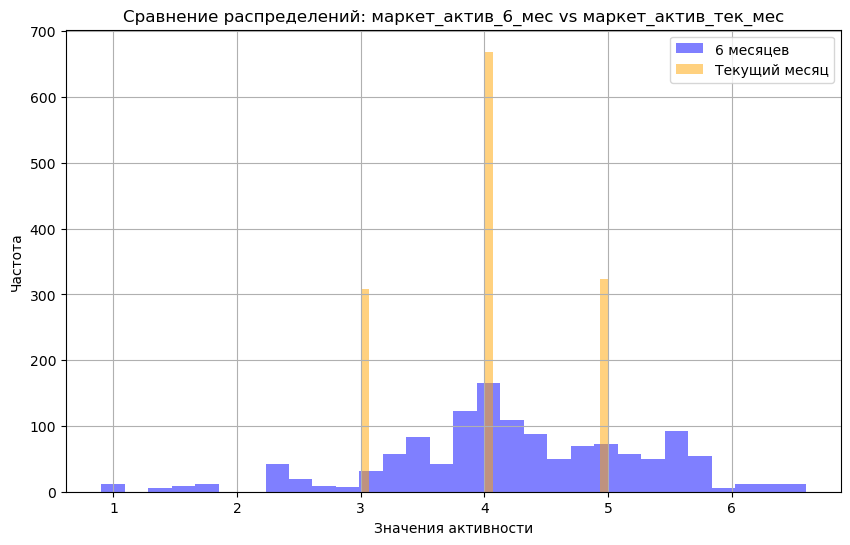

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(market["маркет_актив_6_мес"], bins = 30, alpha = 0.5, label = "6 месяцев", color = "blue")
plt.hist(market["маркет_актив_тек_мес"], bins = 30, alpha = 0.5, label = "Текущий месяц", color = "orange")
plt.xlabel("Значения активности")
plt.ylabel("Частота")
plt.title("Сравнение распределений: маркет_актив_6_мес vs маркет_актив_тек_мес")
plt.legend()
plt.grid(True)
plt.show()

Частота маркетинговой активности мультимодальна с модой 4 и локальной модой вц 5.5 коммуницаций в месяц. Так же заметны значения близкие к выбросам до 2 коммуникаций в месяц.

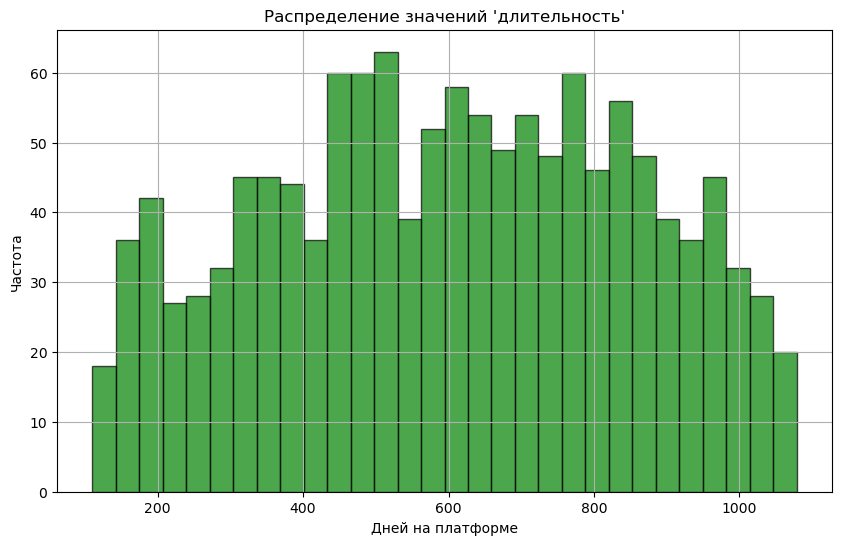

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(market["длительность"], bins = 30, color = "green", edgecolor = "black", alpha = 0.7)
plt.xlabel("Дней на платформе")
plt.ylabel("Частота")
plt.title("Распределение значений 'длительность'")
plt.grid(True)
plt.show()

Длительность пребывания пользователей на платформе распределена схоже с нормальным распеределением без явных выбросов и аномалий.

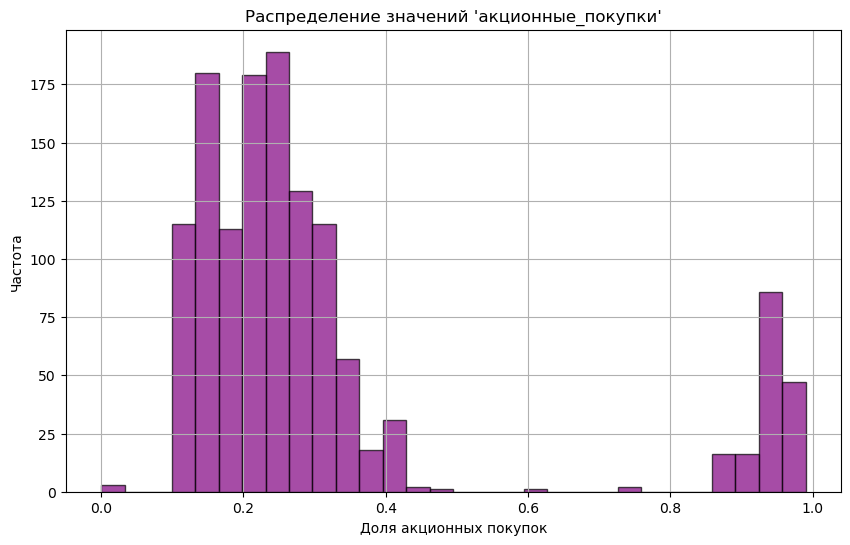

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(market["акционные_покупки"], bins = 30, color = "purple", edgecolor = "black", alpha = 0.7)
plt.xlabel("Доля акционных покупок")
plt.ylabel("Частота")
plt.title("Распределение значений 'акционные_покупки'")
plt.grid(True)
plt.show()

Доля акционных покупок распределена мультимодельно. Большинство пользователей покупает лишь треть покупок по акции. Но так же видно меньшее, но значимое, количество пользователей, которые стремятся покупать все товары по акции. 

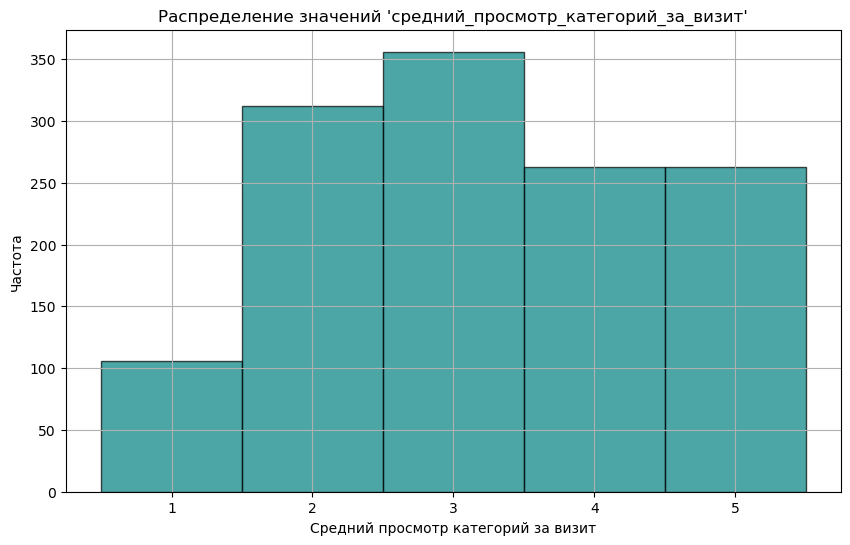

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(market["средний_просмотр_категорий_за_визит"], 
         bins = range(market["средний_просмотр_категорий_за_визит"].min(), 
                    market["средний_просмотр_категорий_за_визит"].max() + 1), 
         align = "left", color = "teal", edgecolor = "black", alpha = 0.7)
plt.xlabel("Средний просмотр категорий за визит")
plt.ylabel("Частота")
plt.title("Распределение значений 'средний_просмотр_категорий_за_визит'")
plt.grid(True)
plt.show()

Большинство пользователей просматривает от 2 до 5 категорий за визит.

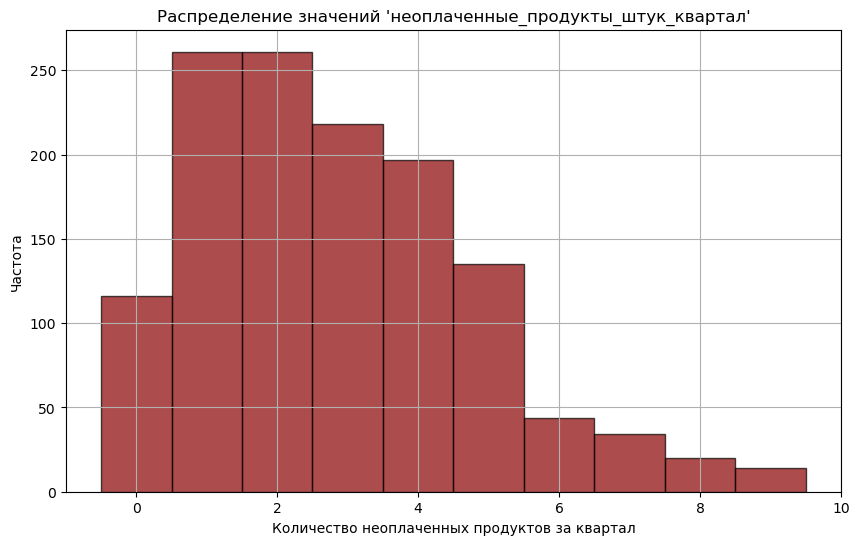

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(market["неоплаченные_продукты_штук_квартал"], 
         bins = range(market["неоплаченные_продукты_штук_квартал"].min(), 
                    market["неоплаченные_продукты_штук_квартал"].max() + 1), 
         align = "left", color = "darkred", edgecolor = "black", alpha = 0.7)
plt.xlabel("Количество неоплаченных продуктов за квартал")
plt.ylabel("Частота")
plt.title("Распределение значений 'неоплаченные_продукты_штук_квартал'")
plt.grid(True)
plt.show()

Распределение количества оставленных в корзине без покупки товаров напоминает распределение Пуассона. Чаще всего пользователи оставляют около 2 таваров в корзине в течение 3 месяцев неоплеченными.

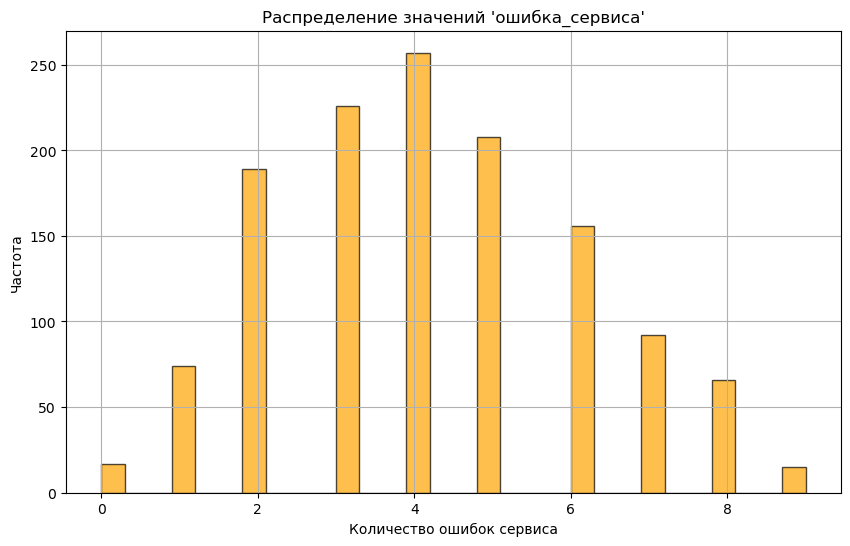

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(market["ошибка_сервиса"], bins = 30, color = "orange", edgecolor = "black", alpha = 0.7)
plt.xlabel("Количество ошибок сервиса")
plt.ylabel("Частота")
plt.title("Распределение значений 'ошибка_сервиса'")
plt.grid(True)
plt.show()

Количество ошибок сервиса, с которыми сталкиваются пользователи в течение квартала при посещении сайта распределно нормально со средним значением в 4 ошибки за 3 месяца.

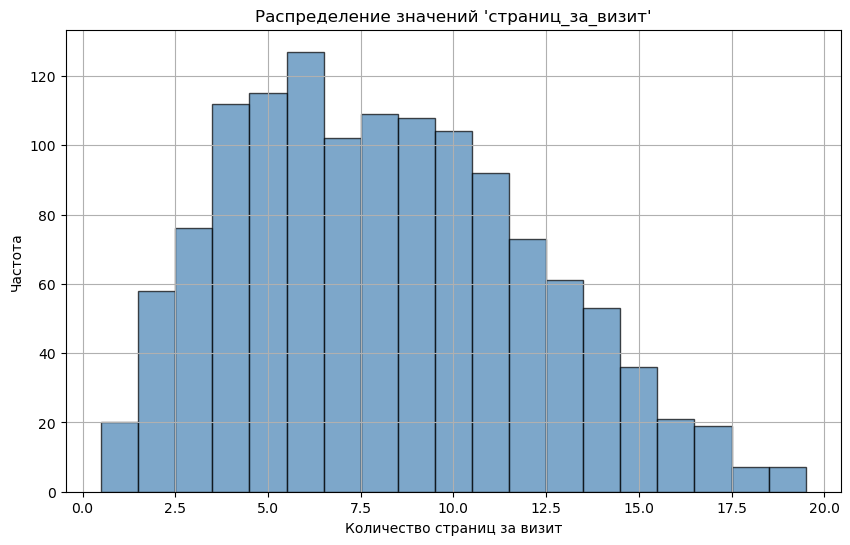

In [43]:
plt.figure(figsize=(10,6))
plt.hist(market["страниц_за_визит"], 
         bins = range(market["страниц_за_визит"].min(), 
                    market["страниц_за_визит"].max() + 1), 
         align = "left", color = "steelblue", edgecolor = "black", alpha = 0.7)
plt.xlabel("Количество страниц за визит")
plt.ylabel("Частота")
plt.title("Распределение значений 'страниц_за_визит'")
plt.grid(True)
plt.show()

Количество просмотренных пользователями страниц за визит в сервис распределно схоже с распределенгием Пуассона. Чаще всего пользователи просматривают около 6 страниц за сессию.

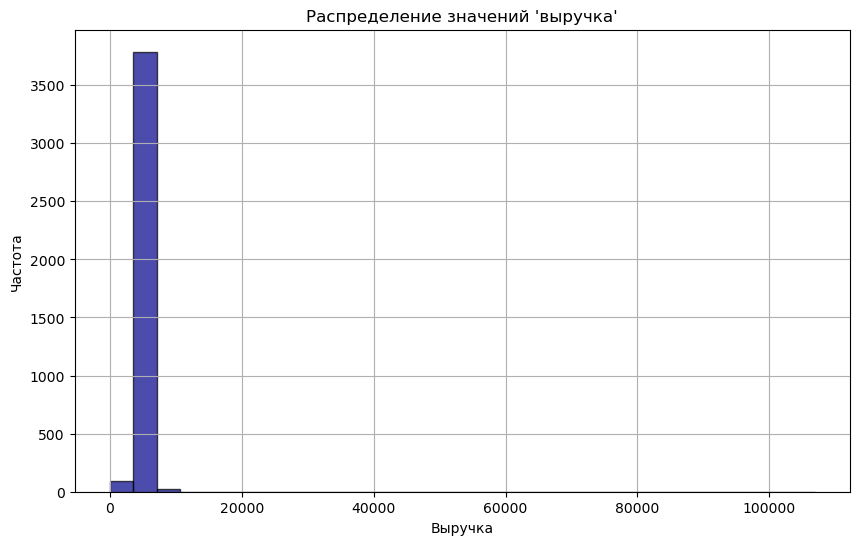

In [44]:
merged_df = pd.merge(market, market_revenue, on = "id", how = "inner")

plt.figure(figsize=(10, 6))
plt.hist(merged_df["выручка"], bins = 30, color = "darkblue", edgecolor = "black", alpha = 0.7)
plt.xlabel("Выручка")
plt.ylabel("Частота")
plt.title("Распределение значений 'выручка'")
plt.grid(True)
plt.show()

Явно заметно наличие аномальных значений выручки на графике. Избавимся от них.

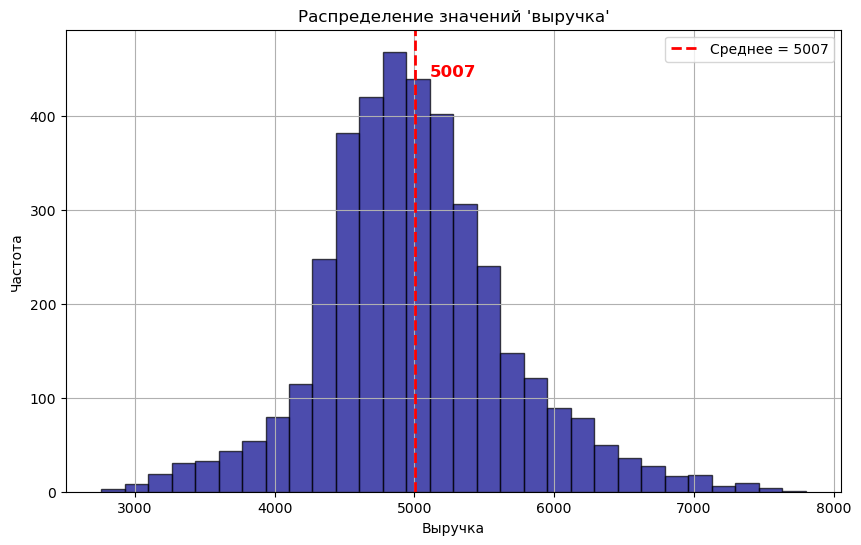

In [45]:
market_revenue = market_revenue[
    (market_revenue["выручка"] <= 20_000) & 
    (market_revenue["выручка"] > 10)
]
merged_df = pd.merge(market, market_revenue, on = "id", how = "inner")
mean_value = merged_df["выручка"].mean()
mean_value_rounded = round(mean_value)

plt.figure(figsize=(10,6))
plt.hist(merged_df["выручка"], bins = 30, color = "darkblue", edgecolor = "black", alpha = 0.7)
plt.axvline(mean_value, color = "red", linestyle = "--", linewidth = 2, label = f"Среднее = {mean_value_rounded}")
plt.text(mean_value * 1.02, plt.ylim()[1]*0.9, str(mean_value_rounded), 
         color = "red", fontsize = 12, fontweight = "bold")
plt.xlabel("Выручка")
plt.ylabel("Частота")
plt.title("Распределение значений 'выручка'")
plt.grid(True)
plt.legend()
plt.show()

После фильтрации выбросов распеределение выручки напоминает нормальное со средним в примерно 5000 у.е.

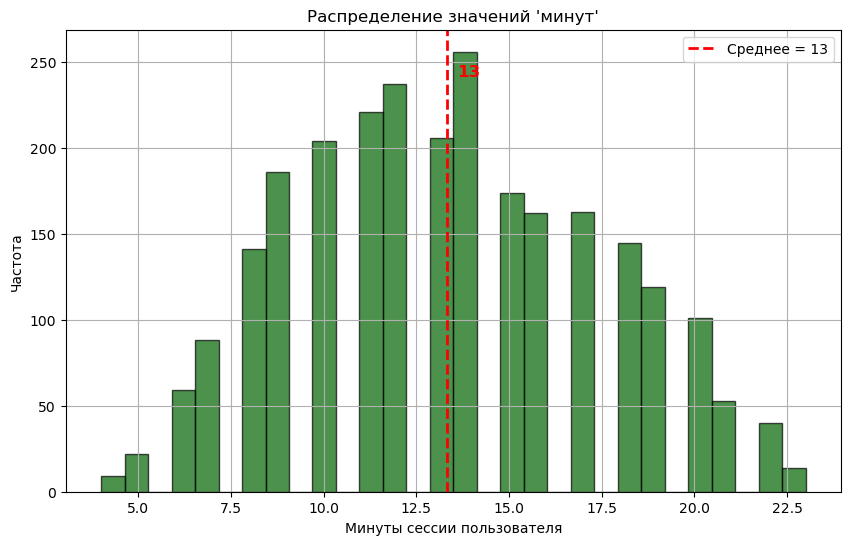

In [46]:
merged_time = pd.merge(market, market_time, on = "id", how = "inner")
mean_minutes = merged_time["минут"].mean()
mean_minutes_rounded = round(mean_minutes)

plt.figure(figsize=(10, 6))
plt.hist(merged_time["минут"], bins = 30, color = "darkgreen", edgecolor = "black", alpha = 0.7)
plt.axvline(mean_minutes, color = "red", linestyle = "--", linewidth = 2, 
            label = f"Среднее = {mean_minutes_rounded}")
plt.text(mean_minutes * 1.02, plt.ylim()[1]*0.9, str(mean_minutes_rounded),
         color = "red", fontsize = 12, fontweight = "bold")
plt.xlabel("Минуты сессии пользователя")
plt.ylabel("Частота")
plt.title("Распределение значений 'минут'")
plt.grid(True)
plt.legend()
plt.show()


Минуты распределены схоже с нормальным распределением со средним в 13 минут проведённых в сервисе за одну сессию. 

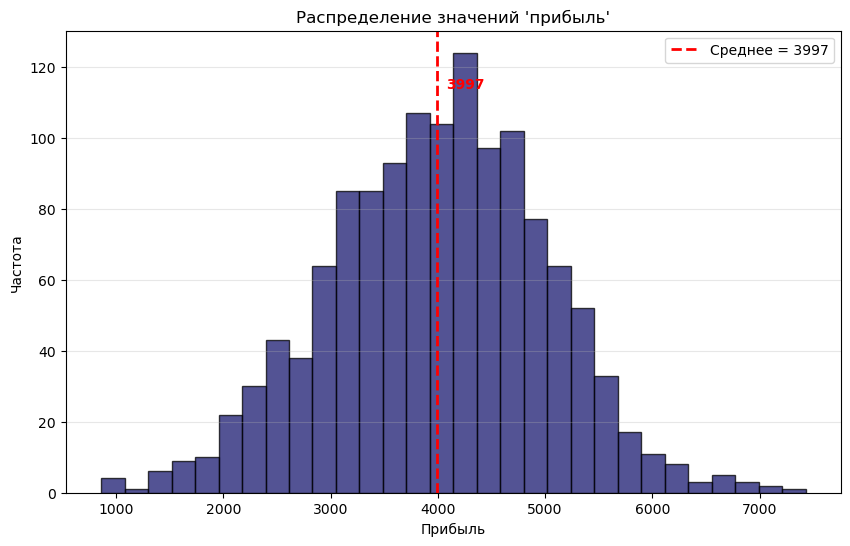

In [47]:
merged_profit = pd.merge(market, profit, on = "id", how = "inner")
mean_val = profit["прибыль"].mean()
mean_val_round = round(mean_val)

plt.figure(figsize = (10, 6))
plt.hist(profit["прибыль"], bins = 30, color = "midnightblue", edgecolor = "black", alpha = 0.75)
plt.axvline(mean_val, color = "red", linestyle = "--", linewidth = 2, label = f"Среднее = {mean_val_round}")

ymax = plt.ylim()[1]

plt.text(mean_val * 1.02, ymax * 0.9, str(mean_val_round),
         color = "red", fontweight = "bold", va = "top")
plt.xlabel("Прибыль")
plt.ylabel("Частота")
plt.title("Распределение значений 'прибыль'")
plt.grid(True, axis = "y", alpha = 0.3)
plt.legend()
plt.show()


Прибыль распределена схоже с нормальным распределениес со средним значением около 4000 у.е.

### Рассмотрим частоты распределения качестыенных характеристик

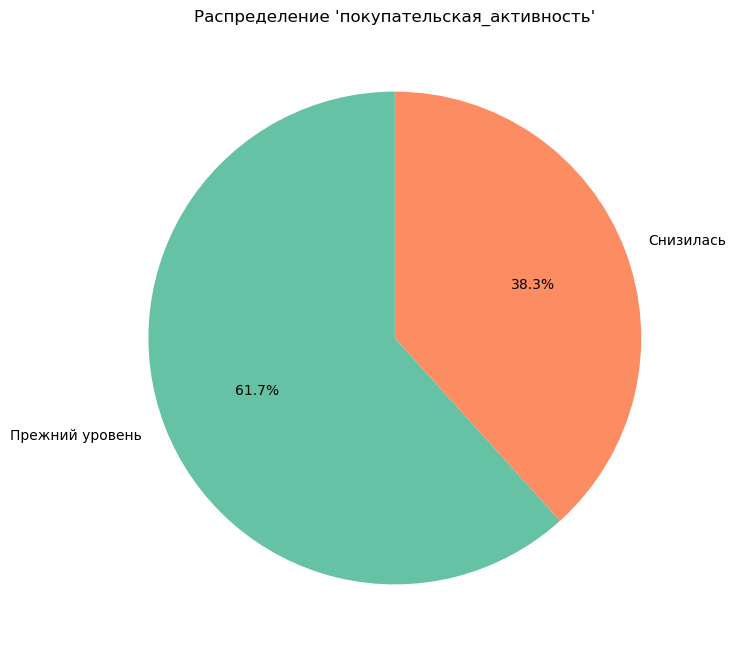

In [48]:
activity_counts = market["покупательская_активность"].value_counts()

plt.figure(figsize = (8, 8))
plt.pie(activity_counts, 
        labels = activity_counts.index, 
        autopct = "%1.1f%%", 
        startangle = 90, 
        colors = plt.cm.Set2.colors)

plt.title("Распределение 'покупательская_активность'")
plt.show()

Примерно у трети пользователей целевой признак покупательской активности снизился в последнее время

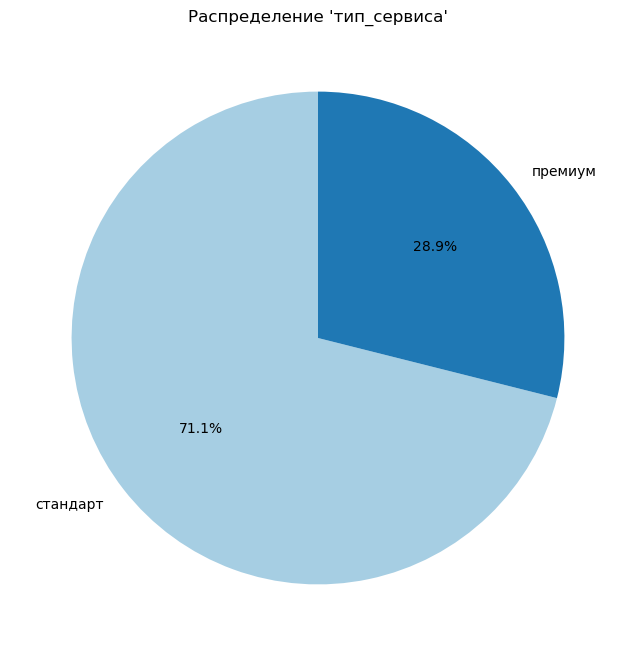

In [49]:
service_counts = market["тип_сервиса"].value_counts()

plt.figure(figsize = (8, 8))
plt.pie(service_counts, 
        labels = service_counts.index, 
        autopct = "%1.1f%%", 
        startangle = 90, 
        colors = plt.cm.Paired.colors)

plt.title("Распределение 'тип_сервиса'")
plt.show()

Чуть менее трети пользователей пользуются подпиской.

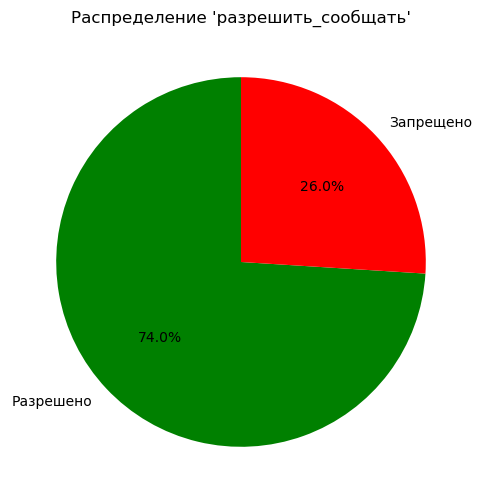

In [50]:
allow_counts = market["разрешить_сообщать"].value_counts()

plt.figure(figsize = (6, 6))
plt.pie(allow_counts, 
        labels = ["Разрешено", "Запрещено"], 
        autopct = "%1.1f%%", 
        startangle = 90, 
        colors = ["green", "red"])

plt.title("Распределение 'разрешить_сообщать'")
plt.show()


Около четверти пользователей запретили присылать им маркетинговые сообщения.

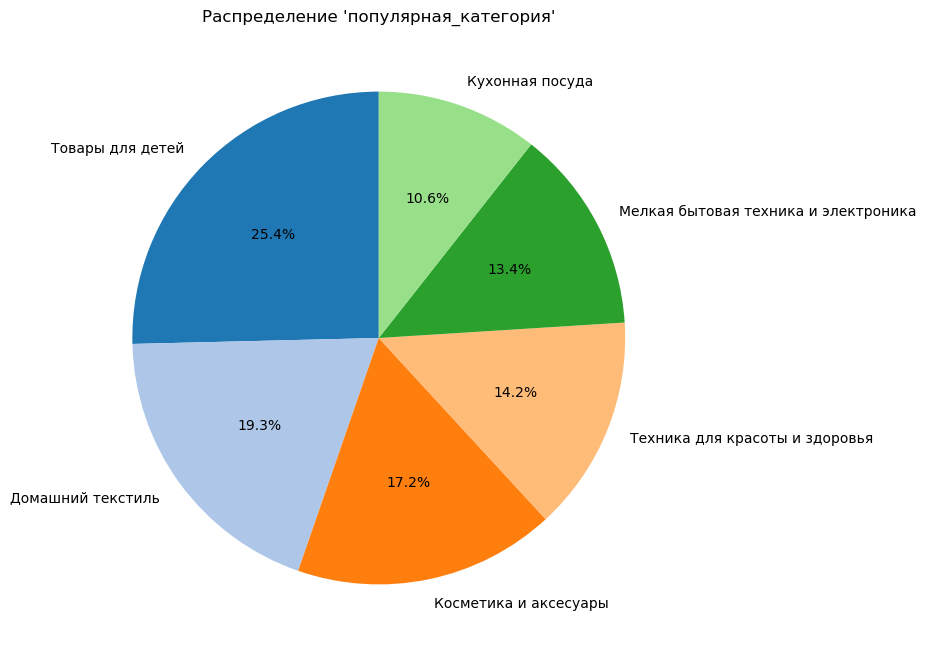

In [51]:
popular_counts = market["популярная_категория"].value_counts()

plt.figure(figsize = (8, 8))
plt.pie(popular_counts, 
        labels = popular_counts.index, 
        autopct = "%1.1f%%", 
        startangle = 90, 
        colors = plt.cm.tab20.colors)  # палитра для множества категорий

plt.title("Распределение 'популярная_категория'")
plt.show()


Чаще всего пользователи покупают товары из дщетской и текстильной категорий.

**Промежуточный вывод**:

Провели ознакомление с данными продаж, очистили данные от выбросов и аномалий.

## Объединим таблицы

In [52]:
merged_profit = pd.merge(market, profit, on = "id", how = "left")

Создадим новые колонки на основании периода.

In [53]:
def add_period_columns(df, col_end):
    for period in df["период"].unique():
        df = df.assign(**{
            f"{period}_{col_end}": df.apply(lambda x: x[col_end] if x["период"] == period else None, axis = 1)
        })
    return df

market_time = market_time.groupby("период", group_keys = False).apply(lambda x: add_period_columns(x, "минут"))
market_time.drop({"минут", "период"}, axis = 1, inplace = True)

In [54]:
market_time.head()

,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215348,NaN,14.0
1,215348,13.0,NaN
2,215349,NaN,10.0
3,215349,12.0,NaN
4,215350,NaN,13.0


In [55]:
merged_time = pd.merge(merged_profit, market_time, on = "id", how = "left")

Создадим новые колонки на основании периода.

In [56]:
market_revenue = market_revenue.groupby("период", group_keys = False).apply(lambda x: add_period_columns(x, "выручка"))
market_revenue.drop({"выручка", "период"}, axis = 1, inplace = True)

In [57]:

merged = pd.merge(merged_time, market_revenue, on = "id", how = "left")
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7786 entries, 0 to 7785
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   7786 non-null   int64   
 1   покупательская_активность            7786 non-null   category
 2   тип_сервиса                          7786 non-null   category
 3   разрешить_сообщать                   7786 non-null   boolean 
 4   маркет_актив_6_мес                   7786 non-null   float64 
 5   маркет_актив_тек_мес                 7786 non-null   int64   
 6   длительность                         7786 non-null   int64   
 7   акционные_покупки                    7786 non-null   float64 
 8   популярная_категория                 7786 non-null   category
 9   средний_просмотр_категорий_за_визит  7786 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   7786 non-null   int64   
 11  ошибка_сервиса   

### Заполним пропуски в новых признаках

Чтобы не искажать статистику заполним пропуски средними.

In [58]:
for col in merged.select_dtypes(include = ["number"]).columns:
    mean_value = merged[col].mean()
    merged[col].fillna(mean_value, inplace = True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7786 entries, 0 to 7785
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   7786 non-null   int64   
 1   покупательская_активность            7786 non-null   category
 2   тип_сервиса                          7786 non-null   category
 3   разрешить_сообщать                   7786 non-null   boolean 
 4   маркет_актив_6_мес                   7786 non-null   float64 
 5   маркет_актив_тек_мес                 7786 non-null   int64   
 6   длительность                         7786 non-null   int64   
 7   акционные_покупки                    7786 non-null   float64 
 8   популярная_категория                 7786 non-null   category
 9   средний_просмотр_категорий_за_визит  7786 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   7786 non-null   int64   
 11  ошибка_сервиса   

## Корреляционный анализ

### Корреляционная матрица

Для начала построим кореляционную матрицу в виде тепловой карты.

['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'прибыль', 'предыдущий_месяц_минут', 'текущий_месяц_минут', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка']
interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'прибыль', 'предыдущий_месяц_минут', 'текущий_месяц_минут', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка']


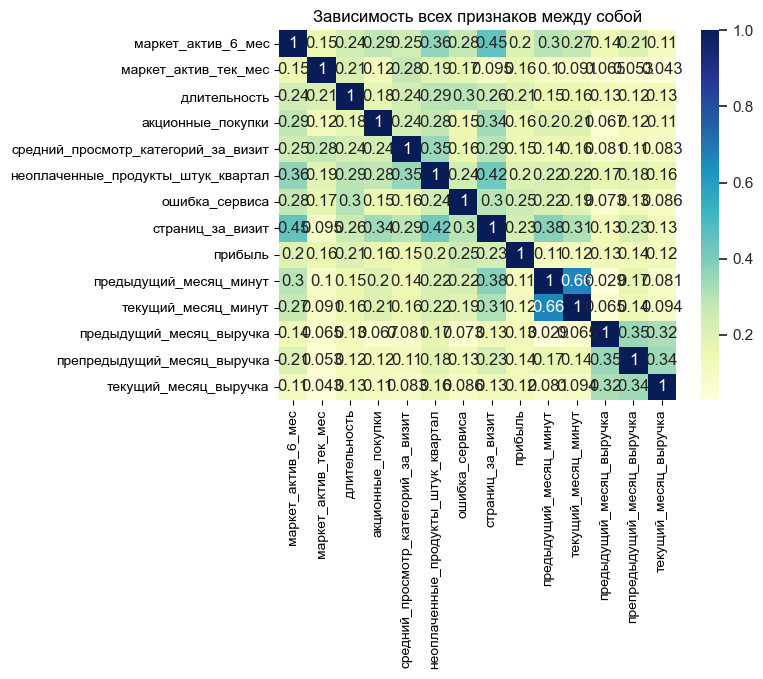

In [59]:
numeric_columns = merged.select_dtypes(include = ["number"]).columns.tolist()
numeric_columns.remove("id")
ax = plt.axes()
sns.set_theme(rc = {"figure.figsize":(10,10)})
print(numeric_columns)
phi_k = merged[numeric_columns].phik_matrix()
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title("Зависимость всех признаков между собой")
plt.show()

### VIF (коэффициент инфляции дисперсии)

Оценим мультиколлинеарность каждого не содержащего пропусков численного признака в данных при помощи рассчёта коэффициента инфляции дисперсии

In [60]:
X = add_constant(merged[numeric_columns])
VIFs = pd.DataFrame()
VIFs["Variable"] = X.columns
VIFs["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIFs.sort_values(by = "VIF", ascending = False))

                               Variable          VIF
0                                 const  1058.829560
8                      страниц_за_визит     1.313357
1                    маркет_актив_6_мес     1.194533
4                     акционные_покупки     1.176680
10               предыдущий_месяц_минут     1.174143
6    неоплаченные_продукты_штук_квартал     1.167104
5   средний_просмотр_категорий_за_визит     1.165200
11                  текущий_месяц_минут     1.100220
13          препредыдущий_месяц_выручка     1.068868
3                          длительность     1.066779
7                        ошибка_сервиса     1.058538
2                  маркет_актив_тек_мес     1.042454
14                текущий_месяц_выручка     1.012207
9                               прибыль     1.008727
12             предыдущий_месяц_выручка     1.004120


Исходя из корелляционной матрицы и анализа VIF делаем вывод, что мультиколлинеарность в данных почти отсутствует. Наиболее скоррелированным с другими признаками является количество просмотренных за визит страниц. Удалим этот признак чтобы добиться большей стабильности линейных моделей.

In [61]:
merged.drop("страниц_за_визит", axis = 1, inplace = True)
numeric_columns.remove("страниц_за_визит")
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7786 entries, 0 to 7785
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   7786 non-null   int64   
 1   покупательская_активность            7786 non-null   category
 2   тип_сервиса                          7786 non-null   category
 3   разрешить_сообщать                   7786 non-null   boolean 
 4   маркет_актив_6_мес                   7786 non-null   float64 
 5   маркет_актив_тек_мес                 7786 non-null   int64   
 6   длительность                         7786 non-null   int64   
 7   акционные_покупки                    7786 non-null   float64 
 8   популярная_категория                 7786 non-null   category
 9   средний_просмотр_категорий_за_визит  7786 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   7786 non-null   int64   
 11  ошибка_сервиса   

## Построение пайплайнов

### Подготовка данных

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    merged.drop(["id","покупательская_активность"], axis=1),
    merged["покупательская_активность"],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = merged["покупательская_активность"])

ohe_columns = ["тип_сервиса", "популярная_категория"]

ohe_pipe = Pipeline(
        [("ohe", OneHotEncoder(drop = "first", handle_unknown = "error", sparse = False))]
    )

numeric_pipe = Pipeline(
    [("num", MinMaxScaler())]
    )

data_preprocessor = ColumnTransformer(
    [("ohe", ohe_pipe, ohe_columns),
     ("num", MinMaxScaler(), numeric_columns)
    ], 
    remainder = "passthrough"
)

### Cоздаём итоговый пайплайн: перебор методов подготовки данных и моделей сразными гиперпараметрами

In [63]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'models__min_samples_split': range(2, 11, 2),
        'models__min_samples_leaf': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), 'passthrough']  
    },
    {
        "models": [KNeighborsClassifier(n_jobs = -1)],
        "models__n_neighbors": range(2, 7),
        "models__weights": ["uniform", "distance"],
        "models__algorithm": ["ball_tree", "kd_tree"],
        "models__leaf_size": range(2, 51, 3),
        "models__p": [1, 2],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]   
    },
    {
        "models": [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver="liblinear",
            n_jobs = -1
        )],
        "models__solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
        "models__penalty": ["l1", "l2", "elasticnet"],
        "models__penalty": ["l1", "l2", "elasticnet"],
        "models__C": [1, 2, 4, 8, 16, 32],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    },
    {
        "models": [SVC(
            random_state=RANDOM_STATE
        )],
        "models__C": [1, 2, 4, 8, 16, 32],
        "models__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "models__degree": [2, 3, 4, 5],
        "models__gamma": ["scale", "auto"],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), "passthrough"]  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter = 30,
    cv = 5,
    scoring = "roc_auc",
    random_state = RANDOM_STATE,
    n_jobs = -1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['тип_сервиса',
                                                                                'популярная_категория']),
                                                                              ('num',
                                                                               MinMaxScaler(),
 

### Выбор метрики

Для задачи выбрана метрика ROC AUC т.к. она более робастная, подходит для задачи бинарной классификации и позволяет объективнее оценить обобщающую способность разных моделей вне зависимости от их гиперпараметров.

In [64]:
print("Лучшая модель и её параметры:\n\n", randomized_search.best_estimator_)
print ("Метрика лучшей модели на тренировочной выборке:", randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:,1]

print(f"Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                             

### Вывод подбора модели

**Наилучшей** моделью оказалась **модель ближайших соседей** с количеством рассматритваемых соседей 3 и расстоянием считаемым по манхеттенской метрике со значением метрики **ROC AUC близким к 1** на тестовой выборке.

## Анализ важности признаков

Для анализа значимости признаков рассчитаем значения Шепли. Семплируем тестовую выборку для адекватного соотношения времени ожидания перебора параметров, репрезентативности выборки и стабильности резултатов.

In [ ]:
def model_predict(x):
    return randomized_search.best_estimator_.predict_proba(x)[:, 1]

sampled_train = shap.sample(X_train, 30, random_state = RANDOM_STATE)
sampled_test = shap.sample(X_test, 30, random_state = RANDOM_STATE)
explainer = shap.KernelExplainer(model_predict, sampled_train, keep_index = True, keep_index_ordered = True)
shap_values = shap.Explanation(explainer.shap_values(sampled_test), feature_names = sampled_test.columns)

  0%|          | 0/20 [00:00<?, ?it/s]

### График влияния признаков на предсказания классов

Построим "рой" значений для оценки вклада признаков.

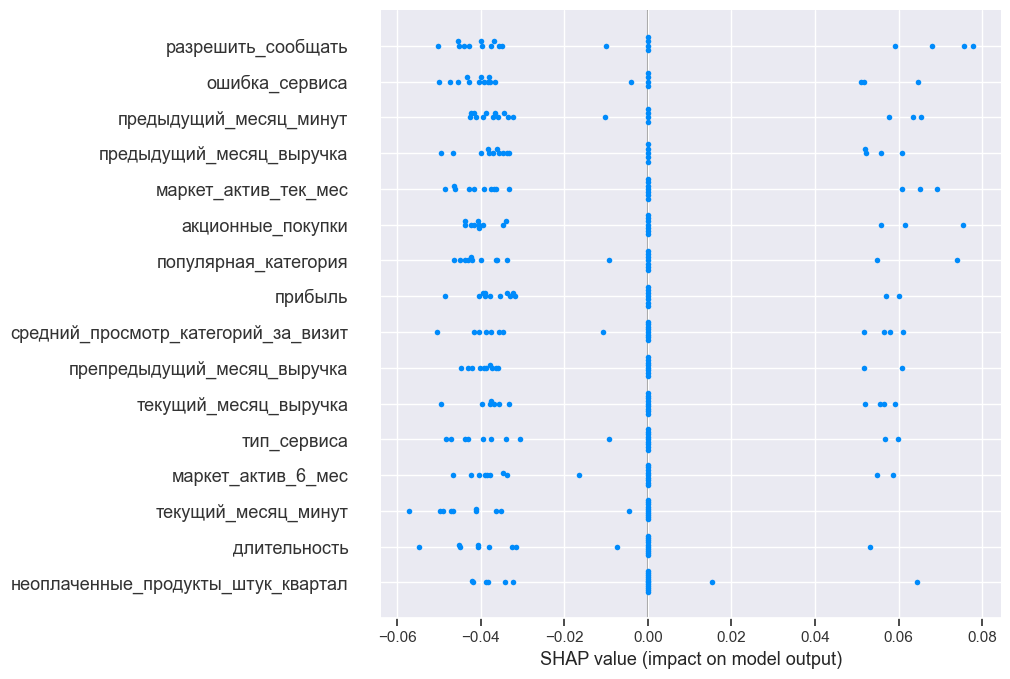

In [66]:
shap.plots.beeswarm(shap_values, max_display = 16) 

- В силу масштабирования данных в ходе предобработки все признаки имеют примерно одинаковые диапазоны значений, что отражено монохромностью точек на графике. 

- Более значимые признаки чаще сильно влияют на присвоение класса, чем менее значимые. 

- Чаще всего конкретные признаки никак не влияют на предсказание модели.

- В более редких случаях, модель чаще склоняется к тому, что пользователь сохранит свою покупательскую активность.

- Заметно, что при снижении покупательской активности пользователей, модель "увереннее" присваивает класс на основании любого из признаков.

- При снижении покупательской активности модель незначительно больше учитывает более значимые признаки, чем менее значимые.

### График значимости признаков

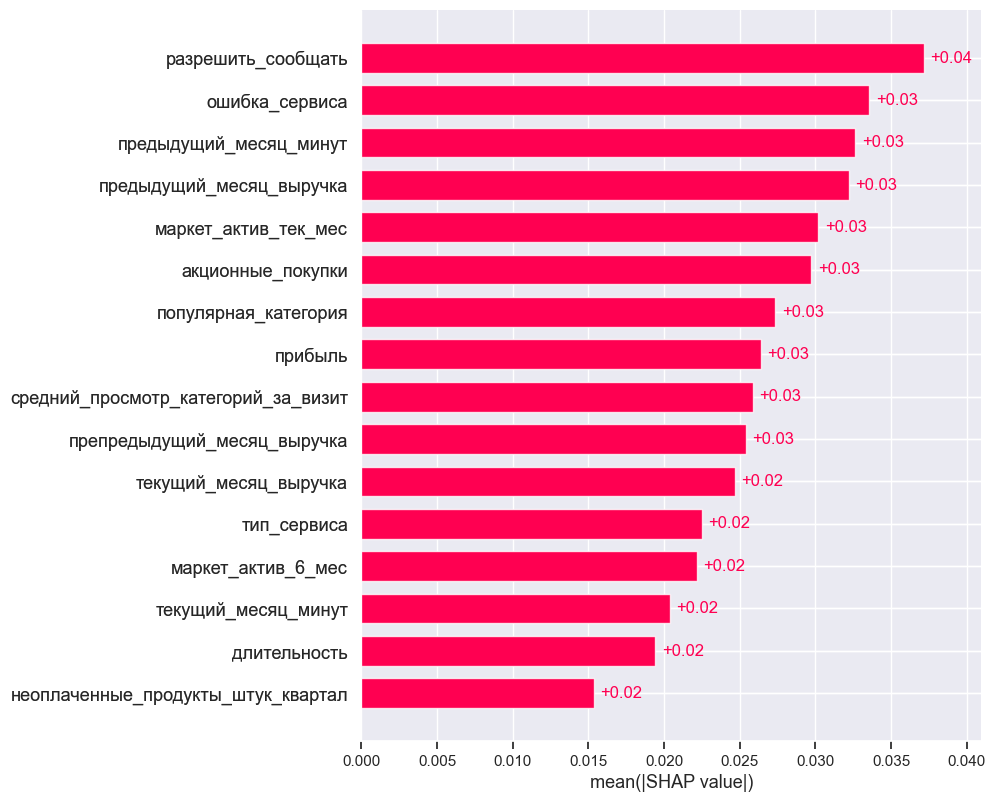

In [67]:
shap.plots.bar(shap_values, max_display = 16)

- Наиболее важными для предсказания покупательской активности являются финансовые показатели  пользователя за предыдущий период и его разрешение маркетинговых коммуникаций с компанией.

- Значимость остальных признаков равномерно убывает, но при этом остаётся достаточно существенной, чтобы их оставить.

- Наименее значимыми оказались количество неоплаченных товаров из корзины за последнее время и наличие маркетинговых коммуникаций за последний месяц.

### Выводы анализа влияния признаков

- Стоит сосредоточиться на финансовых показателях пользователей за предудущие месяцы для оценки их активности в будущем.

- Стоит обратить внимание на возможность маркетинговой коммуникации с пользователем.

## Сегментация покупателей

Применяем модель ко всему набору данных.

In [68]:
X_full = merged.drop(["id", "покупательская_активность"], axis = 1)

predictions = randomized_search.best_estimator_.predict_proba(X_full)[:, 1]

segmented = merged.copy()
segmented["нужно_удержание"] = predictions

Сегментируем покупателей наиболее простой моделью сегментации.

In [69]:
clustering_features = ["прибыль", "нужно_удержание"]
X_cluster = segmented[clustering_features].fillna(segmented[clustering_features].mean())
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
segmented['segment'] = kmeans.fit_predict(X_cluster_scaled)


In [70]:
segmented.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7786 entries, 0 to 7785
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   7786 non-null   int64   
 1   покупательская_активность            7786 non-null   category
 2   тип_сервиса                          7786 non-null   category
 3   разрешить_сообщать                   7786 non-null   boolean 
 4   маркет_актив_6_мес                   7786 non-null   float64 
 5   маркет_актив_тек_мес                 7786 non-null   int64   
 6   длительность                         7786 non-null   int64   
 7   акционные_покупки                    7786 non-null   float64 
 8   популярная_категория                 7786 non-null   category
 9   средний_просмотр_категорий_за_визит  7786 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   7786 non-null   int64   
 11  ошибка_сервиса   

In [71]:
segmented.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,прибыль,предыдущий_месяц_минут,текущий_месяц_минут,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,нужно_удержание,segment
count,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000,7786.000000
mean,215998.649371,4.254868,4.010018,602.619317,0.320141,3.268431,2.840997,4.184690,3997.313126,13.469304,13.208836,4948.339630,4836.367772,5236.787452,0.378757,1.416003
std,374.657602,1.014328,0.696188,249.305586,0.249474,1.354598,1.972357,1.952039,1011.588714,2.781801,2.983647,404.620417,192.399637,482.454466,0.474459,1.218439
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,0.000000,860.000000,5.000000,4.000000,2890.000000,4098.000000,2758.700000,0.000000,0.000000
25%,215674.000000,3.700000,4.000000,408.000000,0.170000,2.000000,1.000000,3.000000,3300.000000,13.000000,13.000000,4948.339630,4836.367772,5236.787452,0.000000,0.000000
50%,215999.000000,4.200000,4.000000,606.000000,0.240000,3.000000,3.000000,4.000000,4040.000000,13.469304,13.208836,4948.339630,4836.367772,5236.787452,0.000000,1.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,4670.000000,13.469304,13.208836,4948.339630,4836.367772,5236.787452,1.000000,3.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,7430.000000,23.000000,23.000000,6869.500000,5663.000000,7799.400000,1.000000,3.000000


Описательная статистика выглядит адекватно. Явных аномалий не замечено.

### Квадранты сегментации клиентов

Порог для удержания: 0.5
Порог для прибыли: 4040.00
Количество пользователей в каждом сегменте:
0    2591
3    2242
1    1607
2    1346
Name: segment, dtype: int64


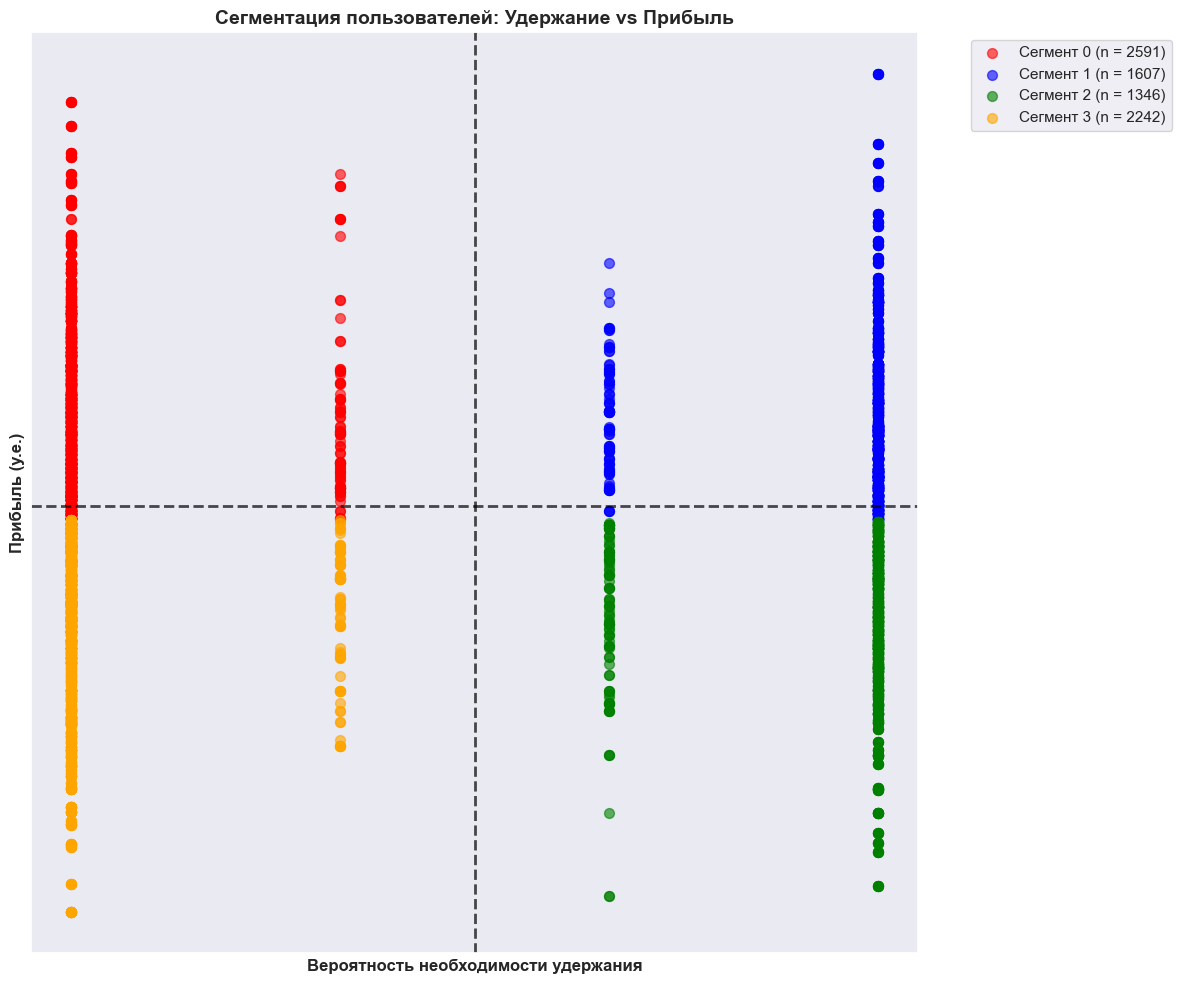

In [72]:
retention_threshold = 0.5
profit_threshold = segmented["прибыль"].median()

print(f"Порог для удержания: {retention_threshold}")
print(f"Порог для прибыли: {profit_threshold:.2f}")
print(f"Количество пользователей в каждом сегменте:")
print(segmented["segment"].value_counts())

plt.figure(figsize = (12, 10))

colors = ["red", "blue", "green", "orange"]
segment_names = ["Сегмент 0", "Сегмент 1", "Сегмент 2", "Сегмент 3"]

for segment_id in range(4):
    segment_data = segmented[segmented["segment"] == segment_id]
    plt.scatter(segment_data["нужно_удержание"],
                segment_data["прибыль"],
                c = colors[segment_id],
                alpha = 0.6,
                s = 50,
                label = f"{segment_names[segment_id]} (n = {len(segment_data)})")

plt.axhline(y = profit_threshold, color = "black", linestyle = "--", linewidth = 2, alpha = 0.7)
plt.axvline(x = retention_threshold, color = "black", linestyle = "--", linewidth = 2, alpha = 0.7)

plt.xlabel("Вероятность необходимости удержания", fontsize = 12, fontweight = "bold")
plt.ylabel("Прибыль (у.е.)", fontsize = 12, fontweight = "bold")
plt.title("Сегментация пользователей: Удержание vs Прибыль", fontsize = 14, fontweight = "bold")



plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.grid(True, alpha = 0.3)

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

Для бизнеса в первую очередь стоит сфокусировать внимание на клиентах с высокой прибыльностью, которые теряют активность.

### Анализ распределения по квадрантам

In [73]:
def get_quadrant(row):
    retention = row["нужно_удержание"]
    profit = row["прибыль"]

    if retention >= retention_threshold and profit >= profit_threshold:
        return "Квадрант 1: Нужно удержание + Высокая прибыль"
    elif retention < retention_threshold and profit >= profit_threshold:
        return "Квадрант 2: Не нужно удержание + Высокая прибыль"
    elif retention < retention_threshold and profit < profit_threshold:
        return "Квадрант 3: Не нужно удержание + Низкая прибыль"
    else:
        return "Квадрант 4: Нужно удержание + Низкая прибыль"

segmented["quadrant"] = segmented.apply(get_quadrant, axis=1)

quadrant_counts = segmented["quadrant"].value_counts()
print("Распределение пользователей по квадрантам:")
print(quadrant_counts)
print("\nПроцентное распределение:")
print(f"{(quadrant_counts / len(segmented) * 100).round(1)} %")

Распределение пользователей по квадрантам:
Квадрант 2: Не нужно удержание + Высокая прибыль    2433
Квадрант 3: Не нужно удержание + Низкая прибыль     2400
Квадрант 1: Нужно удержание + Высокая прибыль       1495
Квадрант 4: Нужно удержание + Низкая прибыль        1458
Name: quadrant, dtype: int64

Процентное распределение:
Квадрант 2: Не нужно удержание + Высокая прибыль    31.2
Квадрант 3: Не нужно удержание + Низкая прибыль     30.8
Квадрант 1: Нужно удержание + Высокая прибыль       19.2
Квадрант 4: Нужно удержание + Низкая прибыль        18.7
Name: quadrant, dtype: float64 %


Пользователей, на которых в первую очередь стоит обратить внимание в текущем наборе данных примерно пятая часть.

### Идеи удержания пользователей

Проверим возможности предоставить пользователям скидки.

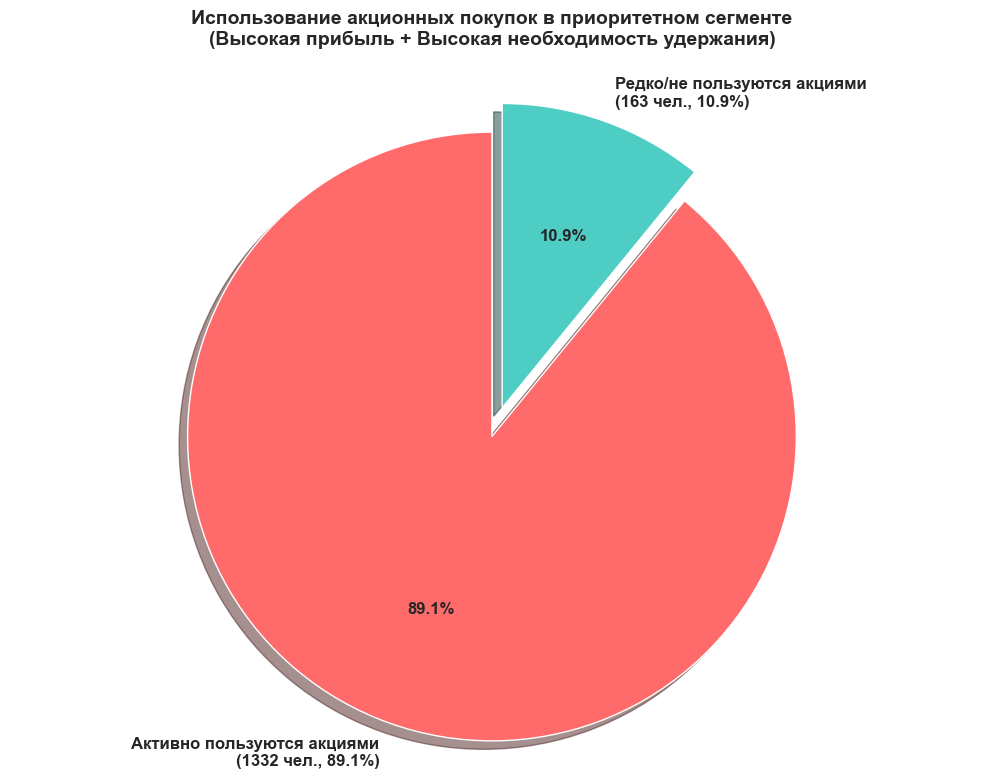

In [74]:
high_value_high_risk = segmented[
    (segmented["нужно_удержание"] >= retention_threshold) &
    (segmented["прибыль"] >= profit_threshold)
]

promo_active_threshold = 0.2

promo_users = high_value_high_risk[high_value_high_risk["акционные_покупки"] > promo_active_threshold]
non_promo_users = high_value_high_risk[high_value_high_risk["акционные_покупки"] <= promo_active_threshold]

promo_counts = [len(promo_users), len(non_promo_users)]
promo_labels = [
    f"Активно пользуются акциями\n({len(promo_users)} чел., {len(promo_users)/len(high_value_high_risk)*100:.1f}%)",
    f"Редко/не пользуются акциями\n({len(non_promo_users)} чел., {len(non_promo_users)/len(high_value_high_risk)*100:.1f}%)"
]

plt.figure(figsize = (10, 8))
colors = ["#FF6B6B", "#4ECDC4"]

plt.pie(promo_counts,
        labels = promo_labels,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.1, 0),
        shadow = True,
        textprops = {"fontsize": 12, "fontweight": "bold"})

plt.title("Использование акционных покупок в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Пользователям, которые совершают менее 20% покупок по акции можно чаще предоставлять скидки.

Проверим количество ошибок сервиса, с которыми сталкиваются премиальные пользователи.

C:\Users\yka\AppData\Local\Temp\ipykernel_19340\1999230833.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_high_risk["service_error_category"] = high_value_high_risk["ошибка_сервиса"].apply(categorize_service_errors)


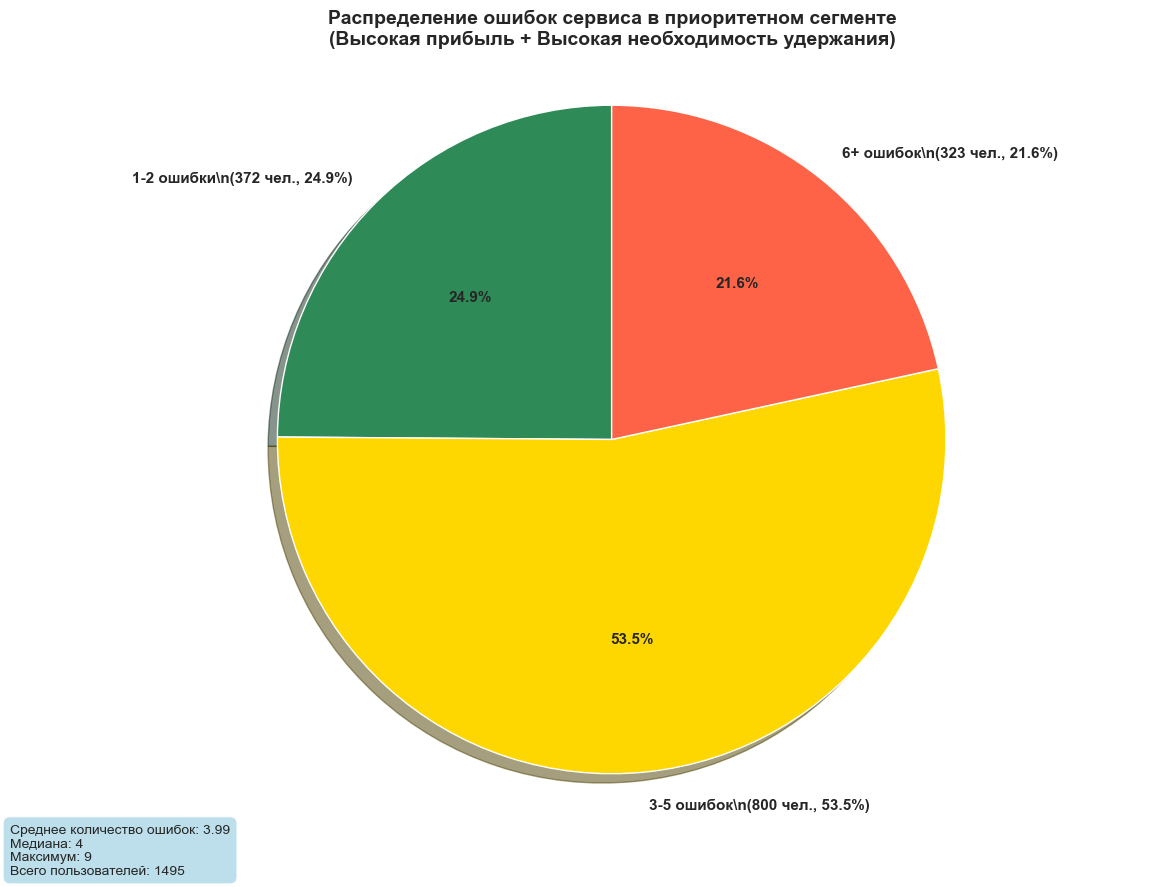

In [75]:
def categorize_service_errors(errors_count):
    if errors_count == 0:
        return "Без ошибок"
    elif errors_count <= 2:
        return "1-2 ошибки"
    elif errors_count <= 5:
        return "3-5 ошибок"
    else:
        return "6+ ошибок"

high_value_high_risk["service_error_category"] = high_value_high_risk["ошибка_сервиса"].apply(categorize_service_errors)
error_categories = high_value_high_risk["service_error_category"].value_counts().sort_index()

plt.figure(figsize = (12, 9))

colors = ["#2E8B57", "#FFD700", "#FF6347", "#DC143C"]

plt.pie(error_categories.values,
        labels = [f"{cat}\\n({count} чел., {count/len(high_value_high_risk)*100:.1f}%)"
                for cat, count in error_categories.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        shadow = True,
        textprops = {"fontsize": 11, "fontweight": "bold"})

plt.title("Распределение ошибок сервиса в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

stats_text = f"Среднее количество ошибок: {high_value_high_risk['ошибка_сервиса'].mean():.2f}\n" \
             f"Медиана: {high_value_high_risk['ошибка_сервиса'].median():.0f}\n" \
             f"Максимум: {high_value_high_risk['ошибка_сервиса'].max()}\n" \
             f"Всего пользователей: {len(high_value_high_risk)}"

plt.text(-1.8, -1.3, stats_text,
         fontsize = 10, bbox = dict(boxstyle = "round,pad=0.5", facecolor = "lightblue", alpha = 0.8))

plt.axis("equal")
plt.tight_layout()
plt.show()

Для премиальных пользователей количество ошибок не сильно отличается от общего распределения для всех клиентов.

Рассмотрим распределение премиальных пользователей по типам сервиса.

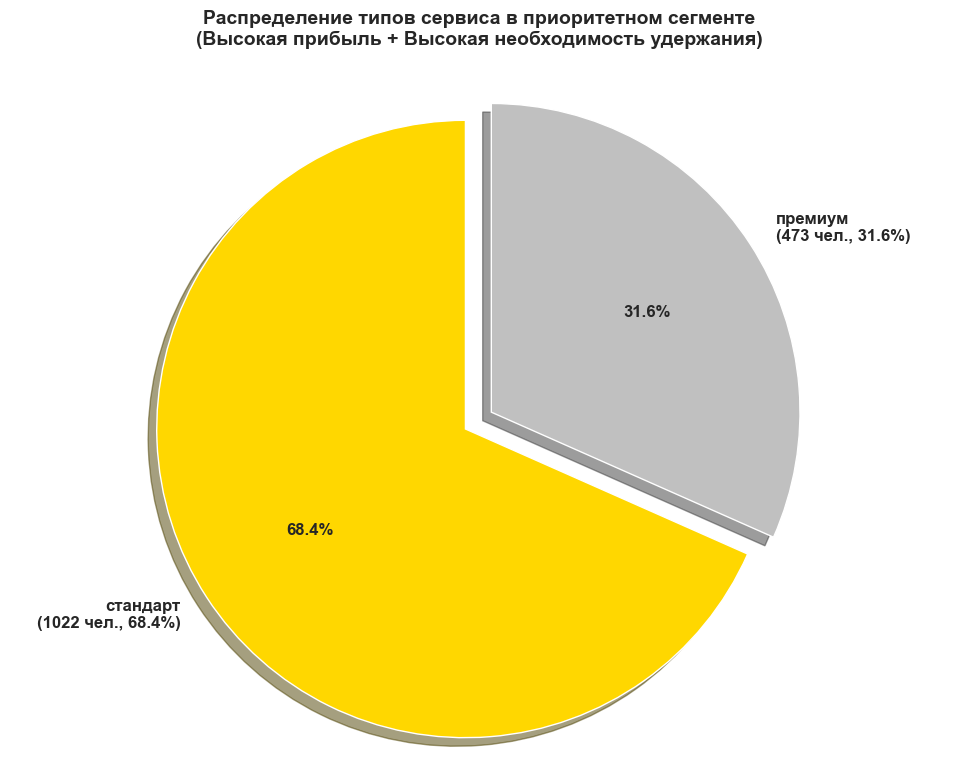

In [76]:
service_type_counts = high_value_high_risk["тип_сервиса"].value_counts()

plt.figure(figsize = (10, 8))

colors = ["#FFD700", "#C0C0C0"]

plt.pie(service_type_counts.values,
        labels = [f"{service_type}\n({count} чел., {count/len(high_value_high_risk)*100:.1f}%)"
                for service_type, count in service_type_counts.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.1, 0),
        shadow = True,
        textprops = {"fontsize": 12, "fontweight": "bold"})

plt.title("Распределение типов сервиса в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Среди премиальных клиентов схожее с общим распределение покупки подписок.

Проанализируем популярные среди премиальных пользователей категории.

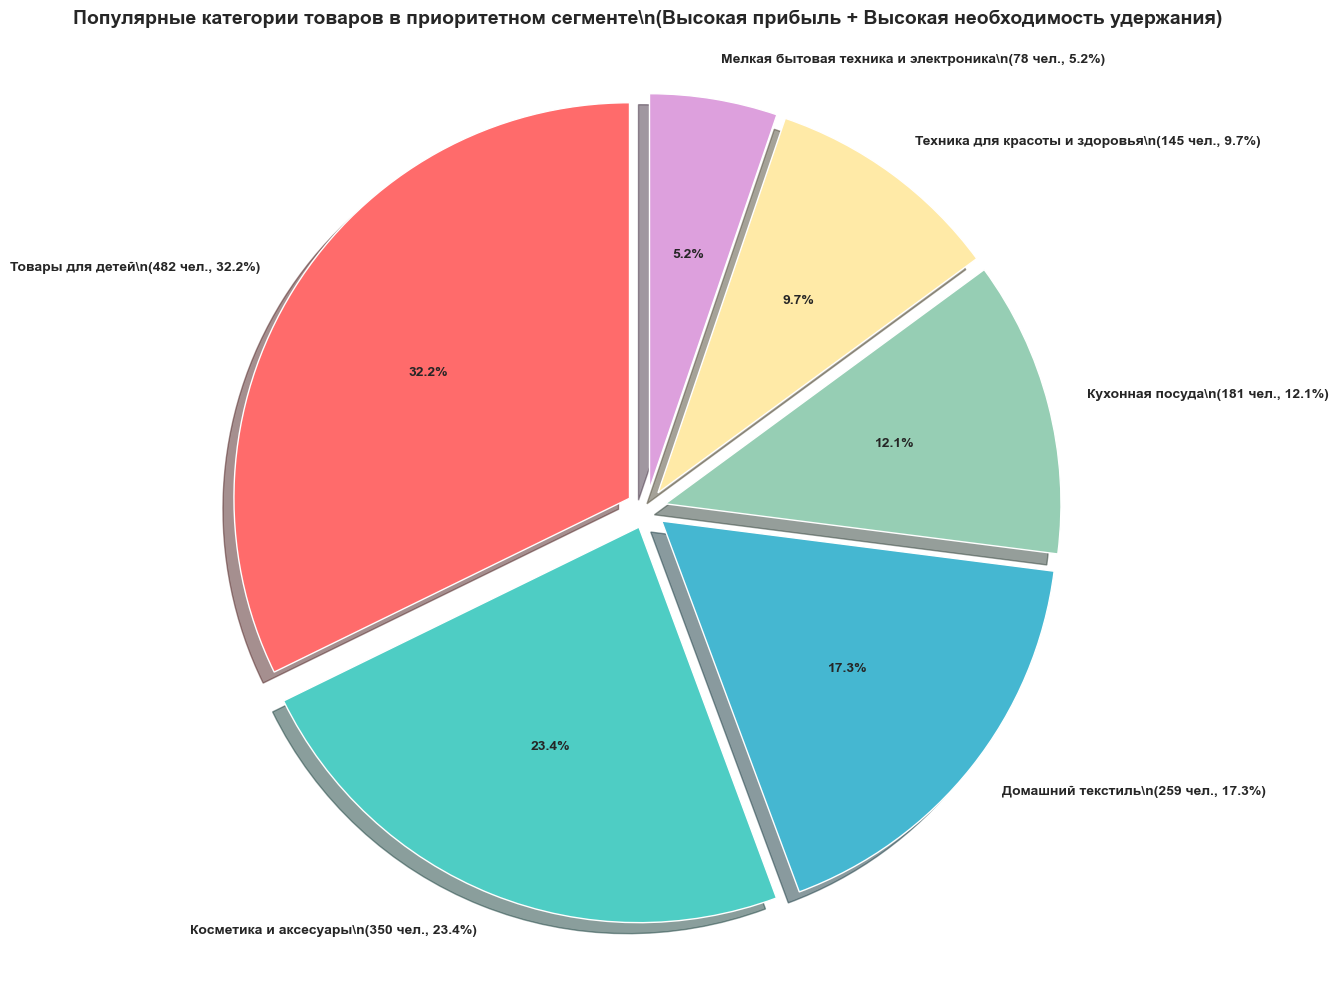

In [77]:
category_counts = high_value_high_risk["популярная_категория"].value_counts()

plt.figure(figsize=(12, 10))

colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7",
          "#DDA0DD", "#98D8C8", "#F7DC6F", "#BB8FCE", "#85C1E9"]

top_categories = category_counts.head(8)
other_count = category_counts[8:].sum()

if other_count > 0:
    top_categories["Другие"] = other_count

plt.pie(top_categories.values,
        labels = [f"{cat}\\n({count} чел., {count/len(high_value_high_risk)*100:.1f}%)"
                for cat, count in top_categories.items()],
        colors = colors[:len(top_categories)],
        autopct = "%1.1f%%",
        startangle = 90,
        explode = [0.05] * len(top_categories),
        shadow = True,
        textprops = {"fontsize": 10, "fontweight": "bold"})

plt.title("Популярные категории товаров в приоритетном сегменте\\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

plt.axis("equal")
plt.tight_layout()
plt.show()

Схожие со всеми остальными пользователями значения популярности категорий товаров.

Проанализируем частоту маркетинговых активностей для премиальных пользователей за последние 6 месяцев.

C:\Users\yka\AppData\Local\Temp\ipykernel_19340\3719003191.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_high_risk["marketing_category"] = high_value_high_risk["маркет_актив_6_мес"].apply(categorize_marketing_activity)


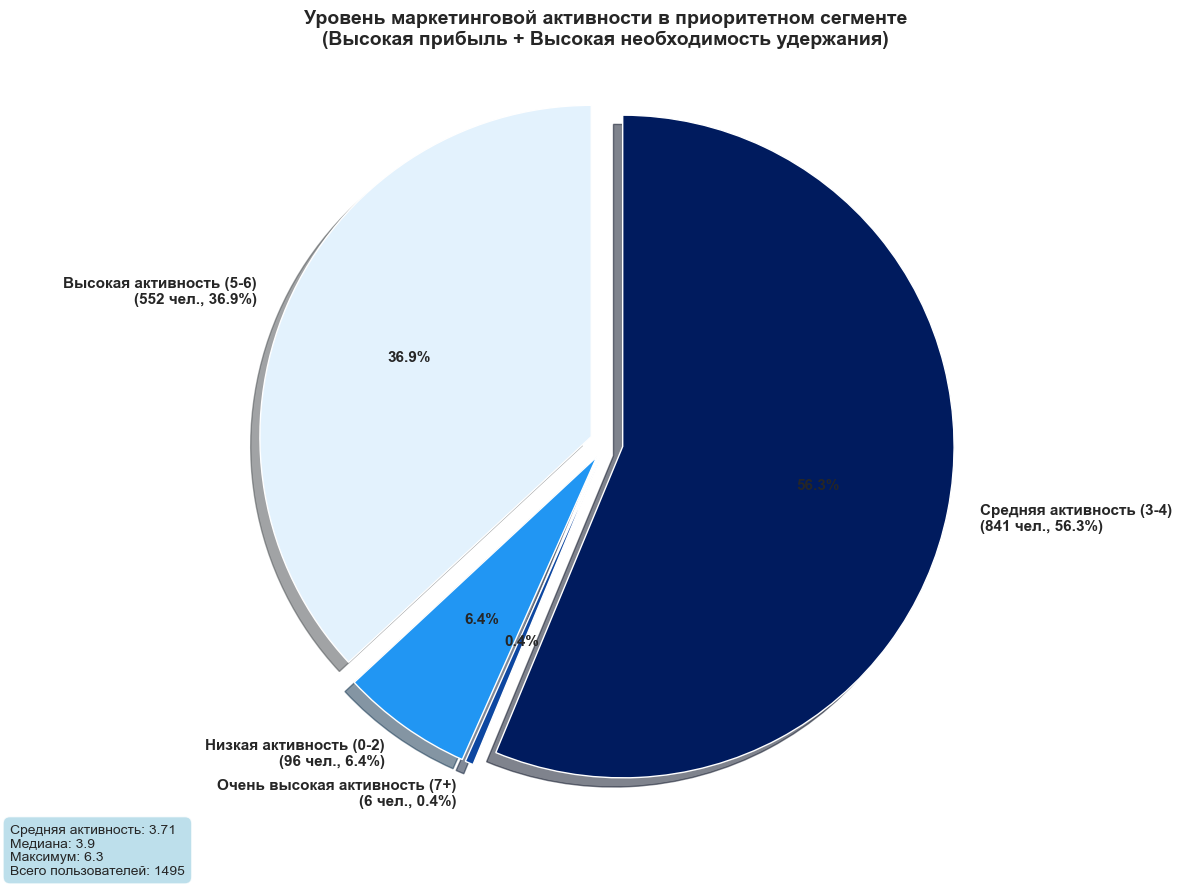

In [78]:
def categorize_marketing_activity(activity_level):
    if activity_level <= 2:
        return "Низкая активность (0-2)"
    elif activity_level <= 4:
        return "Средняя активность (3-4)"
    elif activity_level <= 6:
        return "Высокая активность (5-6)"
    else:
        return "Очень высокая активность (7+)"

high_value_high_risk["marketing_category"] = high_value_high_risk["маркет_актив_6_мес"].apply(categorize_marketing_activity)
marketing_categories = high_value_high_risk["marketing_category"].value_counts().sort_index()


plt.figure(figsize = (12, 9))

colors = ["#E3F2FD", "#2196F3", "#0D47A1", "#001B5E"]

plt.pie(marketing_categories.values,
        labels = [f"{cat}\n({count} чел., {count/len(high_value_high_risk)*100:.1f}%)"
                for cat, count in marketing_categories.items()],
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        explode = (0.05, 0.05, 0.05, 0.05),
        shadow = True,
        textprops = {"fontsize": 11, "fontweight": "bold"})

plt.title("Уровень маркетинговой активности в приоритетном сегменте\n(Высокая прибыль + Высокая необходимость удержания)",
          fontsize = 14, fontweight = "bold", pad = 20)

avg_activity = high_value_high_risk["маркет_актив_6_мес"].mean()
median_activity = high_value_high_risk["маркет_актив_6_мес"].median()
max_activity = high_value_high_risk["маркет_актив_6_мес"].max()

stats_text = f"Средняя активность: {avg_activity:.2f}\n" \
             f"Медиана: {median_activity:.1f}\n" \
             f"Максимум: {max_activity:.1f}\n" \
             f"Всего пользователей: {len(high_value_high_risk)}"

plt.text(-1.8, -1.3, stats_text,
         fontsize=10, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.axis("equal")
plt.tight_layout()
plt.show()

Для большинства пользователей из премиальной категории с высокой вероятноситью снижения активности за последние 6 месяцев наблюдалась высокая либо средняя маркетинговая активность. Вероятно, пользователям надоедает излишне назойливая реклама. Есть смысл изменить маркетиинговую статегию для премиальных пользователей.

## Итоговые выводы

### Задача

Была поставлена **задача** построения модели для **предсказания покупательской активности** клиентов и выяснения **способов их удержания**.

### Подготовка данных

Были получены и подготовлены 4 файла с данными:
- унификация называний признаков
- фильтрация дубликатов
- преобразования типов данных
- обработаны пропуски
- исправлены описки
- расспотрена описательная статистика
- построены графики частот для количественных и качественных признаков
- обхеденены наборы данных из 4 файлов

### Поиск модели

Для поиска модели были **опробованы 4 алгоритма** классификации **с разными наборами** целесообразных **гиперпараметров** случайным образом.

### Лучшая модель классификации

В качестве **лучшей модели предсказания активности** клиента была получена модель **ближайших соседей с точностью** ROC AUC близкой к **идеальной**.

### **Идеи удержания клиентов**

В качестве основного для бизнеса был выделен **"премиальный" сегмент клиентов** с относительно высокой прибылью для бизнеса (~ 19% от всех пользователей), **теряющих интерес** к сервису.

**Рекомендации**:
- предоставить временную повышенную скидку на все товары для пользователей, которые покупают меньше 20% товаров со скидкой
- поменять маркетинговую стратегию для "премиального" сегмента пользователей